In [33]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [34]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


ライブラリの読み込み

In [35]:
import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布の確認
import pandas_profiling as pdp 
# 可視化
import matplotlib.pyplot as plt 
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder 
# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotlibで日本語表示したい場合はこれをinstallしてインポートする
# !pip install japanize-matplotlib
# import japanize_matplotlib
# %matplotlib inline

ファイルの読み込み

In [36]:
df_train = pd.read_csv("../data/train.csv")

In [37]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 4.4　データの確認

In [38]:
# レコード数（行数）とカラム数（列数）の確認
print(df_train.shape)
print("レコード数:", len(df_train))
print("カラム数:", len(df_train.columns))

(891, 12)
レコード数: 891
カラム数: 12


In [39]:
# データ型の確認
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [40]:
# data型の変換必要な場合は適宜行う
df_train["Pclass"] = df_train["Pclass"].astype(object)
df_train["Pclass"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Pclass
Non-Null Count  Dtype 
--------------  ----- 
891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [41]:
df_train["Pclass"] = df_train["Pclass"].astype(np.int64)
df_train["Pclass"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Pclass
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


In [42]:
# 欠損値の確認
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 4.5　データセットの作成

In [43]:
x_train, y_train, id_train = df_train[['Pclass', 'Fare']], df_train[['Survived']], df_train[['PassengerId']] 

In [44]:
print(x_train.shape, y_train.shape, id_train.shape)

(891, 2) (891, 1) (891, 1)


ホールドアウト検証と交差検証

まずはホールドアウト検証

In [45]:
print(len(df_train[df_train['Survived']==1]) / len(df_train['Survived']))

0.3838383838383838


In [46]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print(f"y_train:{y_train['Survived'].mean():.3f}, y_tr:{y_tr['Survived'].mean():.3f}, y_va:{y_va['Survived'].mean():.3f}")

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


次に、5-Fold cross validation

In [47]:
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print(f"y_train:{y_train['Survived'].mean():.3f}, y_tr:{y_tr['Survived'].mean():.3f}, y_va:{y_va['Survived'].mean():.3f}")
    
# ここでモデル学習（次節で説明）

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 2 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 3 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
-------------------- 4 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.383, y_va:0.388


### 4.7　モデルの学習

テーブルデータを用いた教師あり学習の場合はとりあえず「LightGBM」を用いておけば問題ない。

##### 4.7.1 ホールドアウト検証の場合
- データセットの作成
- モデル学習
- 精度の評価
- 説明変数の重要度算出

データセットの作成

In [48]:
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape)
print(f"y_train:{y_train['Survived'].mean():.3f}, y_tr:{y_tr['Survived'].mean():.3f}, y_va:{y_va['Survived'].mean():.3f}")

(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385


モデル学習

In [49]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': '0.1',
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)], early_stopping_rounds=100, verbose=10)

[10]	training's auc: 0.792256	valid_1's auc: 0.744862
[20]	training's auc: 0.801914	valid_1's auc: 0.752372
[30]	training's auc: 0.808339	valid_1's auc: 0.759223
[40]	training's auc: 0.816595	valid_1's auc: 0.759223
[50]	training's auc: 0.820771	valid_1's auc: 0.755138
[60]	training's auc: 0.82582	valid_1's auc: 0.754809
[70]	training's auc: 0.82995	valid_1's auc: 0.753755
[80]	training's auc: 0.832645	valid_1's auc: 0.752767
[90]	training's auc: 0.834593	valid_1's auc: 0.750132
[100]	training's auc: 0.837247	valid_1's auc: 0.747892
[110]	training's auc: 0.839036	valid_1's auc: 0.746838
[120]	training's auc: 0.840764	valid_1's auc: 0.746311
[130]	training's auc: 0.842007	valid_1's auc: 0.746706


LGBMClassifier(importance_type='gain', learning_rate='0.1', metric='auc',
               n_estimators=100000, num_leaves=16, objective='binary',
               random_state=123)

精度の評価

In [50]:
y_tr_pred = model.predict(x_tr)
y_va_pred = model.predict(x_va)
metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print(f"[accuracy] tr: {metric_tr:.2f}, va: {metric_va:.2f}")

[accuracy] tr: 0.75, va: 0.73


説明変数の重要度

In [51]:
imp = pd.DataFrame({'col': x_train.columns, 'imp': model.feature_importances_})
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp
0,Fare,903.440373
1,Pclass,229.457186


##### 4.7.2　クロスバリデーションの場合

データセットの作成、モデル学習、精度の評価

In [52]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': '0.1',
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

metrics = []
imp = pd.DataFrame()

n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(x_train, y_train))

for nfold in np.arange(n_splits):
    print("-"*20, nfold, "-"*20)
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = x_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    x_va, y_va = x_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print(f"y_train:{y_train['Survived'].mean():.3f}, y_tr:{y_tr['Survived'].mean():.3f}, y_va:{y_va['Survived'].mean():.3f}")

    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)], early_stopping_rounds=100, verbose=10)

    y_tr_pred = model.predict(x_tr)
    y_va_pred = model.predict(x_va)
    metric_tr = accuracy_score(y_tr, y_tr_pred)
    metric_va = accuracy_score(y_va, y_va_pred)
    print(f"[accuracy] tr: {metric_tr:.2f}, va: {metric_va:.2f}")

    metrics.append([nfold, metric_tr, metric_va])
    _imp = pd.DataFrame({'col': x_train.columns, 'imp': model.feature_importances_, 'nfold': nfold})
    imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

print("-"*20, 'result', "-"*20)
metrics = np.array(metrics)
print(metrics)

print(f"[cv] tr: {metrics[:,1].mean():.2f}+-{metrics[:,1].std():.2f}, va: {metrics[:,2].mean():.2f}+-{metrics[:,2].std():.2f}")

imp = imp.groupby('col')['imp'].agg(['mean', 'std'])
imp.columns = ['imp', 'imp_std']
imp = imp.reset_index(drop=False)

print('Done.')

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
y_train:0.384, y_tr:0.383, y_va:0.385
[10]	training's auc: 0.788155	valid_1's auc: 0.736957
[20]	training's auc: 0.805606	valid_1's auc: 0.731686
[30]	training's auc: 0.814213	valid_1's auc: 0.734256
[40]	training's auc: 0.82194	valid_1's auc: 0.731028
[50]	training's auc: 0.826838	valid_1's auc: 0.730632
[60]	training's auc: 0.832653	valid_1's auc: 0.732082
[70]	training's auc: 0.835966	valid_1's auc: 0.724045
[80]	training's auc: 0.839696	valid_1's auc: 0.71693
[90]	training's auc: 0.843037	valid_1's auc: 0.716206
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
[110]	training's auc: 0.847218	valid_1's auc: 0.71726
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
y_train:0.384, y_tr:0.384, y_va:0.382
[10]	training's auc: 0.786679	valid_1's auc: 0.74873
[20]	training's auc: 0.800014	valid_1's auc: 0.752874
[30]	training's auc: 0.808685	vali

説明変数の重要度の算出

In [53]:
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,679.390270,356.992896
1,Pclass,291.704529,138.843896


##### 4.7.3　ベースラインの評価

ベースラインの評価の観点
- モデルの精度
- 誤差の分布
- 予測値の分布

In [54]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 2) (712, 1)
(179, 2) (179, 1)


In [55]:
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr, y_tr, test_size=0.2, shuffle=True, stratify=y_tr, random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 2) (569, 1)
(143, 2) (143, 1)


In [56]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': '0.1',
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr1, y_tr1, eval_set=[(x_tr1, y_tr1), (x_va1, y_va1)], early_stopping_rounds=100, verbose=10)

[10]	training's auc: 0.792153	valid_1's auc: 0.72562
[20]	training's auc: 0.810025	valid_1's auc: 0.712087
[30]	training's auc: 0.822545	valid_1's auc: 0.72376
[40]	training's auc: 0.829204	valid_1's auc: 0.719421
[50]	training's auc: 0.836699	valid_1's auc: 0.720455
[60]	training's auc: 0.841808	valid_1's auc: 0.716322
[70]	training's auc: 0.84684	valid_1's auc: 0.71281
[80]	training's auc: 0.851009	valid_1's auc: 0.716529
[90]	training's auc: 0.85472	valid_1's auc: 0.720041
[100]	training's auc: 0.856354	valid_1's auc: 0.722934


LGBMClassifier(importance_type='gain', learning_rate='0.1', metric='auc',
               n_estimators=100000, num_leaves=16, objective='binary',
               random_state=123)

In [57]:
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

In [58]:
print(f"[検証データ] acc: {accuracy_score(y_va1, y_va1_pred):.4f}")
print(f"[ベースライン検証データ] acc: {accuracy_score(y_va2, y_va2_pred):.4f}")

[検証データ] acc: 0.7133
[ベースライン検証データ] acc: 0.7095


In [59]:
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))
print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
ベースライン検証データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


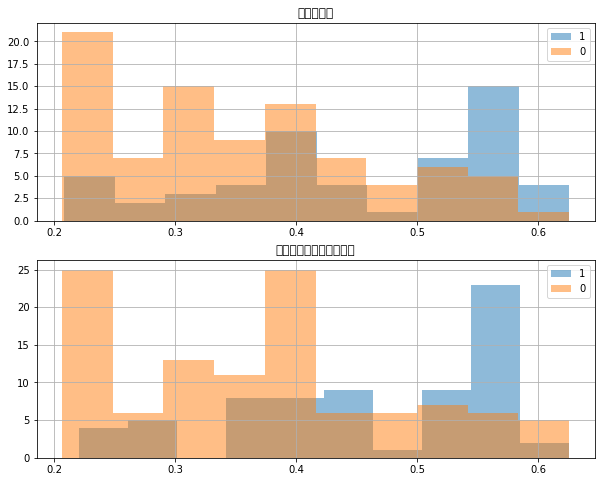

In [60]:
# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))
# 検証データ
fig.add_subplot(2, 1, 1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証データ
fig.add_subplot(2, 1, 2)
plt.title("ベースライン検証データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

### 4.8　モデル推論

##### 4.8.1　推論用データセット作成

In [61]:
df_test = pd.read_csv('../data/test.csv')
x_test = df_test[['Pclass', 'Fare']]
id_test = df_test[['PassengerId']]

##### 4.8.2　学習済モデルを用いた推論

In [62]:
# 学習モデルによる推論
y_test_pred = model.predict(x_test)

In [63]:
# 提出用ファイルの作成
df_submit = pd.DataFrame({'PassengerId':id_test['PassengerId'], 'Survived':y_test_pred})
display(df_submit.head(5))
df_submit.to_csv('../data/submission_baseline.csv', index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
